In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from scipy.sparse import hstack
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from statistics import mean


In [4]:
start = time.time()

# 6 class labels
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


# reading the data file
data = pd.read_csv('../dataset.csv')


# assigning comment and id to X
cols = [0,1]
X = data[data.columns[cols]]


# assigning labels to Y
cols1 = [2,3,4,5,6,7]
Y = data[data.columns[cols1]]


# splitiing the data

# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25)

# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.10)


# taking only the comments from X
train_comment = X_train['comment_text']
test_comment = X_test['comment_text']
all_comments = pd.concat([train_comment, test_comment])


In [5]:
# using tf-idf on words
tf_idf_word = TfidfVectorizer(ngram_range=(1, 1), max_features=10000, stop_words='english', analyzer='word', 
                              sublinear_tf=True, strip_accents='unicode', token_pattern=r'\w{1,}')

# fit and transform for tf_idf_word
tf_idf_word.fit(train_comment)

train_word = tf_idf_word.transform(train_comment)
test_word = tf_idf_word.transform(test_comment)


In [6]:
# using tf-idf on characters to improve the list of bad words
tf_idf_char = TfidfVectorizer(ngram_range=(2, 6), max_features=50000, stop_words='english', analyzer='char', 
                              sublinear_tf=True, strip_accents='unicode')

# fit and transform for tf_idf_char
tf_idf_char.fit(train_comment)

train_char = tf_idf_char.transform(train_comment)
test_char = tf_idf_char.transform(test_comment)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:538: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(


In [7]:
# using hstack() to concatenate the tf_idf_word and tf_idf_char
train_features = hstack([train_char, train_word])
test_features = hstack([test_char, test_word])


In [8]:
scores = []

result = pd.DataFrame.from_dict({'id': X_test['id']})
result1 = pd.DataFrame.from_dict({'id': X_test['id']})

for x in class_names:
    train_target = y_train[x]
    
    # Logistic Regression Classifier
    classifier = LogisticRegression(C=0.1, solver='sag')
    
    # cross_validation_method for state-of-the-art
    cvs = np.mean(cross_val_score(classifier, train_features, train_target, cv=3, scoring='roc_auc'))
    scores.append(cvs)
    print('Cross-Validation Score for class {} is {}'.format(x, cvs))
    
    # using classifier to generate results
    m=classifier.fit(train_features, train_target)
    
    result[x] = classifier.predict(test_features)
    result1[x] = m.predict_proba(test_features)[:, 1]

print()
print('Total Cross-Validation Score is {}'.format(np.mean(scores)))


Cross-Validation Score for class toxic is 0.9691123412085876
Cross-Validation Score for class severe_toxic is 0.9874085697402739
Cross-Validation Score for class obscene is 0.9843188105699775
Cross-Validation Score for class threat is 0.9831624221489715
Cross-Validation Score for class insult is 0.9776098515256115
Cross-Validation Score for class identity_hate is 0.9743046186885058

Total Cross-Validation Score is 0.979319435646988


In [9]:
# taking values of generated output (only class-labels)
cols = [1,2,3,4,5,6]
result_new = result[result.columns[cols]]
result_new1 = result1[result1.columns[cols]]


In [10]:
print(classification_report(y_test.values,result_new.values,target_names=class_names))


               precision    recall  f1-score   support

        toxic       0.97      0.53      0.68      1508
 severe_toxic       0.56      0.14      0.23       141
      obscene       0.95      0.54      0.69       839
       threat       0.00      0.00      0.00        45
       insult       0.86      0.45      0.59       778
identity_hate       0.89      0.06      0.11       142

    micro avg       0.93      0.47      0.62      3453
    macro avg       0.70      0.29      0.38      3453
 weighted avg       0.91      0.47      0.61      3453
  samples avg       0.05      0.04      0.04      3453



/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


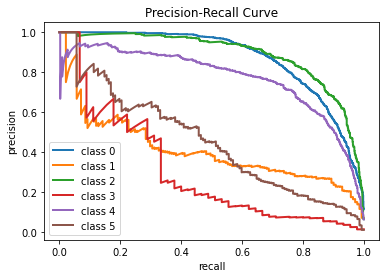

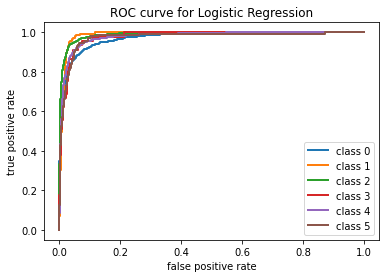

ROC Score:  0.9807336738316781


In [11]:
y_test_new = y_test.values
y_score = result_new1.values

# generating precision-recall curve
precision = dict()
recall = dict()

for i in range(6):
    precision[i], recall[i], _ = precision_recall_curve(y_test_new[:, i], y_score[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("Precision-Recall Curve")
plt.show()


# generating roc curve and roc score
fpr = dict()
tpr = dict()
roc_score=[]

for i in range(6):
    roc_score.append(roc_auc_score(y_test_new[:, i], y_score[:, i]))
#     print(i," ",roc_auc_score(y_test_new[:, i], y_score[:, i]))
    
    fpr[i], tpr[i], _ = roc_curve(y_test_new[:, i], y_score[:, i])
    plt.plot(fpr[i], tpr[i], lw=2, label='class {}'.format(i))

plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc="best")
plt.title("ROC curve for Logistic Regression")
plt.show()
print("ROC Score: ",mean(roc_score))


In [12]:
# calculating overall accuracy by checking the predicted output against the given output

a=y_test.values.tolist()
b=result_new.values.tolist()

count=0
for i in range(len(y_test)):
    if a[i] == b[i]:
        count+=1
print("Accuracy: ",count/len(y_test)*100)


Accuracy:  91.82854994360196


In [13]:
end = time.time()

print("Time: ",(end-start))


Time:  1064.5739657878876
